<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:08:42] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


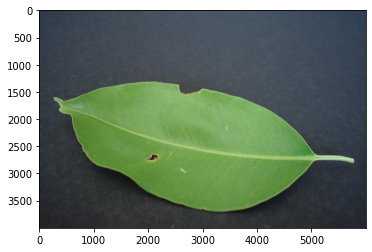

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

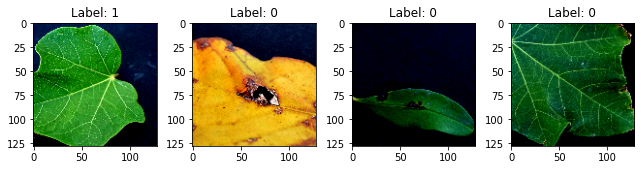

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:08:48] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:08:50] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2602554341196188 samples/sec                   batch loss = 0.2897185981273651 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.265308665122201 samples/sec                   batch loss = 0.4278346300125122 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2702191612785068 samples/sec                   batch loss = 1.4409786462783813 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2708643053755875 samples/sec                   batch loss = 1.024865984916687 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2718598138485762 samples/sec                   batch loss = 0.22652983665466309 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2711987294389453 samples/sec                   batch loss = 0.5419394373893738 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2667867469702123 samples/sec                   batch loss = 1.101489543914795 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.27062714718985 samples/sec                   batch loss = 0.3975382149219513 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2734349199033639 samples/sec                   batch loss = 0.6596512198448181 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2667198908175052 samples/sec                   batch loss = 0.8267666101455688 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.262393315518946 samples/sec                   batch loss = 0.41327613592147827 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2674531115622387 samples/sec                   batch loss = 0.98831707239151 | accuracy = 0.575


Epoch[1] Batch[65] Speed: 1.2660159864436842 samples/sec                   batch loss = 0.48889675736427307 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2703997933099702 samples/sec                   batch loss = 0.4422898292541504 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.2661056037865708 samples/sec                   batch loss = 0.45071491599082947 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2658409921373552 samples/sec                   batch loss = 1.1164288520812988 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2683074999423574 samples/sec                   batch loss = 0.7977811098098755 | accuracy = 0.5911764705882353


Epoch[1] Batch[90] Speed: 1.2673216588956684 samples/sec                   batch loss = 0.6137793064117432 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2707965368608056 samples/sec                   batch loss = 0.3961856961250305 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.26235475150396 samples/sec                   batch loss = 0.7249559164047241 | accuracy = 0.6025


Epoch[1] Batch[105] Speed: 1.2620574317879416 samples/sec                   batch loss = 0.32721948623657227 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2685323790289957 samples/sec                   batch loss = 0.7980574369430542 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.2665087520614378 samples/sec                   batch loss = 0.6865810751914978 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.2634703545036636 samples/sec                   batch loss = 0.3383864760398865 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.2672259348569508 samples/sec                   batch loss = 0.2833169400691986 | accuracy = 0.622


Epoch[1] Batch[130] Speed: 1.2661676172423892 samples/sec                   batch loss = 0.6650395393371582 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.267403993136148 samples/sec                   batch loss = 0.2661897540092468 | accuracy = 0.6333333333333333


Epoch[1] Batch[140] Speed: 1.2630220701927692 samples/sec                   batch loss = 0.8590805530548096 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.2712325379209155 samples/sec                   batch loss = 0.6844353079795837 | accuracy = 0.6327586206896552


Epoch[1] Batch[150] Speed: 1.267665140027706 samples/sec                   batch loss = 0.6988421678543091 | accuracy = 0.63


Epoch[1] Batch[155] Speed: 1.2732779681729383 samples/sec                   batch loss = 0.6397666335105896 | accuracy = 0.6290322580645161


Epoch[1] Batch[160] Speed: 1.2669330134312653 samples/sec                   batch loss = 0.7904943227767944 | accuracy = 0.6296875


Epoch[1] Batch[165] Speed: 1.2695929257864118 samples/sec                   batch loss = 0.5631455183029175 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.263746160300939 samples/sec                   batch loss = 0.6434007883071899 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.267172335711375 samples/sec                   batch loss = 0.6218753457069397 | accuracy = 0.6357142857142857


Epoch[1] Batch[180] Speed: 1.2753780777972892 samples/sec                   batch loss = 0.8447421789169312 | accuracy = 0.6319444444444444


Epoch[1] Batch[185] Speed: 1.2730651207260255 samples/sec                   batch loss = 0.5726720690727234 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.270308989957215 samples/sec                   batch loss = 0.4973943829536438 | accuracy = 0.6355263157894737


Epoch[1] Batch[195] Speed: 1.2738053208343032 samples/sec                   batch loss = 0.7136254906654358 | accuracy = 0.6371794871794871


Epoch[1] Batch[200] Speed: 1.27100737458121 samples/sec                   batch loss = 0.3438652455806732 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.2702128141222648 samples/sec                   batch loss = 0.5484992265701294 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.269715336771064 samples/sec                   batch loss = 1.355309247970581 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2701967541769001 samples/sec                   batch loss = 0.812843918800354 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2581361976204533 samples/sec                   batch loss = 0.7580132484436035 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2605034150059207 samples/sec                   batch loss = 0.35869312286376953 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.263205987114215 samples/sec                   batch loss = 0.24868175387382507 | accuracy = 0.65


Epoch[1] Batch[235] Speed: 1.2704860877619923 samples/sec                   batch loss = 0.5690305829048157 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.2669487996009128 samples/sec                   batch loss = 0.33894485235214233 | accuracy = 0.6552083333333333


Epoch[1] Batch[245] Speed: 1.26846696887098 samples/sec                   batch loss = 0.4353804290294647 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2670496490226277 samples/sec                   batch loss = 0.581919252872467 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.2680833714967825 samples/sec                   batch loss = 0.6582157015800476 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.2677439744776962 samples/sec                   batch loss = 0.3198900520801544 | accuracy = 0.6576923076923077


Epoch[1] Batch[265] Speed: 1.2721619635370334 samples/sec                   batch loss = 0.48783063888549805 | accuracy = 0.6575471698113208


Epoch[1] Batch[270] Speed: 1.2637315961145632 samples/sec                   batch loss = 0.495164692401886 | accuracy = 0.6555555555555556


Epoch[1] Batch[275] Speed: 1.2644951927642594 samples/sec                   batch loss = 1.1510236263275146 | accuracy = 0.6563636363636364


Epoch[1] Batch[280] Speed: 1.2658055597701585 samples/sec                   batch loss = 0.6170030832290649 | accuracy = 0.6553571428571429


Epoch[1] Batch[285] Speed: 1.2701371339800651 samples/sec                   batch loss = 0.685194730758667 | accuracy = 0.6543859649122807


Epoch[1] Batch[290] Speed: 1.26291976938179 samples/sec                   batch loss = 0.480347216129303 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.2622421124802214 samples/sec                   batch loss = 0.36072003841400146 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2651935901504248 samples/sec                   batch loss = 0.5927984118461609 | accuracy = 0.6583333333333333


Epoch[1] Batch[305] Speed: 1.266506075029158 samples/sec                   batch loss = 0.31796708703041077 | accuracy = 0.659016393442623


Epoch[1] Batch[310] Speed: 1.2647963321152433 samples/sec                   batch loss = 0.7881876826286316 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2627914414296086 samples/sec                   batch loss = 0.641987144947052 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.2634920491473025 samples/sec                   batch loss = 0.34054258465766907 | accuracy = 0.659375


Epoch[1] Batch[325] Speed: 1.2615250564058436 samples/sec                   batch loss = 0.33325421810150146 | accuracy = 0.66


Epoch[1] Batch[330] Speed: 1.2661406707417804 samples/sec                   batch loss = 0.7788664698600769 | accuracy = 0.6636363636363637


Epoch[1] Batch[335] Speed: 1.2570362064773581 samples/sec                   batch loss = 0.49523016810417175 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2553057064383777 samples/sec                   batch loss = 0.5913061499595642 | accuracy = 0.6639705882352941


Epoch[1] Batch[345] Speed: 1.266419746805364 samples/sec                   batch loss = 1.0054270029067993 | accuracy = 0.663768115942029


Epoch[1] Batch[350] Speed: 1.2710738173983573 samples/sec                   batch loss = 0.7343998551368713 | accuracy = 0.6642857142857143


Epoch[1] Batch[355] Speed: 1.2664807393911806 samples/sec                   batch loss = 0.7346022725105286 | accuracy = 0.6633802816901408


Epoch[1] Batch[360] Speed: 1.2706281095036034 samples/sec                   batch loss = 0.6237725019454956 | accuracy = 0.6652777777777777


Epoch[1] Batch[365] Speed: 1.265698224220416 samples/sec                   batch loss = 0.3967415392398834 | accuracy = 0.6664383561643835


Epoch[1] Batch[370] Speed: 1.267970762000032 samples/sec                   batch loss = 0.37132328748703003 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.2660799975368469 samples/sec                   batch loss = 1.2731525897979736 | accuracy = 0.6673333333333333


Epoch[1] Batch[380] Speed: 1.272169101907342 samples/sec                   batch loss = 0.513293445110321 | accuracy = 0.6671052631578948


Epoch[1] Batch[385] Speed: 1.2691826272566717 samples/sec                   batch loss = 0.37072423100471497 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.2640109443238865 samples/sec                   batch loss = 0.6385281085968018 | accuracy = 0.6647435897435897


Epoch[1] Batch[395] Speed: 1.2649695116641173 samples/sec                   batch loss = 0.5185896158218384 | accuracy = 0.6658227848101266


Epoch[1] Batch[400] Speed: 1.2755744363789114 samples/sec                   batch loss = 1.0115303993225098 | accuracy = 0.665625


Epoch[1] Batch[405] Speed: 1.27945511486426 samples/sec                   batch loss = 0.5522591471672058 | accuracy = 0.6660493827160494


Epoch[1] Batch[410] Speed: 1.273040777755149 samples/sec                   batch loss = 0.3561151623725891 | accuracy = 0.6658536585365854


Epoch[1] Batch[415] Speed: 1.2687920721065737 samples/sec                   batch loss = 0.6679284572601318 | accuracy = 0.6656626506024096


Epoch[1] Batch[420] Speed: 1.2717983984809873 samples/sec                   batch loss = 0.5023945569992065 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2684727231597137 samples/sec                   batch loss = 0.43301746249198914 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.265067566044205 samples/sec                   batch loss = 0.6351335644721985 | accuracy = 0.6680232558139535


Epoch[1] Batch[435] Speed: 1.2732154495348122 samples/sec                   batch loss = 0.2774999439716339 | accuracy = 0.6695402298850575


Epoch[1] Batch[440] Speed: 1.2728754247542062 samples/sec                   batch loss = 0.5334951877593994 | accuracy = 0.6693181818181818


Epoch[1] Batch[445] Speed: 1.2692242981038666 samples/sec                   batch loss = 0.550241231918335 | accuracy = 0.6696629213483146


Epoch[1] Batch[450] Speed: 1.2702301246977876 samples/sec                   batch loss = 0.6350052356719971 | accuracy = 0.67


Epoch[1] Batch[455] Speed: 1.2707016345843314 samples/sec                   batch loss = 0.3010093867778778 | accuracy = 0.6714285714285714


Epoch[1] Batch[460] Speed: 1.2724650288987749 samples/sec                   batch loss = 0.26779451966285706 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.27440048231681 samples/sec                   batch loss = 0.8188526630401611 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.2630501202430517 samples/sec                   batch loss = 0.6359568238258362 | accuracy = 0.6734042553191489


Epoch[1] Batch[475] Speed: 1.2572985627846816 samples/sec                   batch loss = 0.358115553855896 | accuracy = 0.6726315789473685


Epoch[1] Batch[480] Speed: 1.26224078296592 samples/sec                   batch loss = 0.7902400493621826 | accuracy = 0.6723958333333333


Epoch[1] Batch[485] Speed: 1.2625281181115706 samples/sec                   batch loss = 0.21772895753383636 | accuracy = 0.6747422680412372


Epoch[1] Batch[490] Speed: 1.2606942723873111 samples/sec                   batch loss = 1.4181780815124512 | accuracy = 0.6729591836734694


Epoch[1] Batch[495] Speed: 1.2615249615483088 samples/sec                   batch loss = 0.3356328010559082 | accuracy = 0.6722222222222223


Epoch[1] Batch[500] Speed: 1.271801676388442 samples/sec                   batch loss = 1.0759718418121338 | accuracy = 0.6715


Epoch[1] Batch[505] Speed: 1.2694953213831652 samples/sec                   batch loss = 0.25629767775535583 | accuracy = 0.6727722772277228


Epoch[1] Batch[510] Speed: 1.2710888402154996 samples/sec                   batch loss = 0.43013831973075867 | accuracy = 0.6735294117647059


Epoch[1] Batch[515] Speed: 1.2745201429249167 samples/sec                   batch loss = 0.29775840044021606 | accuracy = 0.6747572815533981


Epoch[1] Batch[520] Speed: 1.2691655372396229 samples/sec                   batch loss = 0.8609902858734131 | accuracy = 0.6740384615384616


Epoch[1] Batch[525] Speed: 1.2713269414936463 samples/sec                   batch loss = 0.4433390498161316 | accuracy = 0.6752380952380952


Epoch[1] Batch[530] Speed: 1.2679173872940095 samples/sec                   batch loss = 0.35648390650749207 | accuracy = 0.6740566037735849


Epoch[1] Batch[535] Speed: 1.2717906858242154 samples/sec                   batch loss = 0.34632954001426697 | accuracy = 0.6752336448598131


Epoch[1] Batch[540] Speed: 1.270525053981663 samples/sec                   batch loss = 0.41049641370773315 | accuracy = 0.675


Epoch[1] Batch[545] Speed: 1.2702067555322973 samples/sec                   batch loss = 0.3900724947452545 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.2652526517210858 samples/sec                   batch loss = 0.675550103187561 | accuracy = 0.6763636363636364


Epoch[1] Batch[555] Speed: 1.2665303599505866 samples/sec                   batch loss = 0.4075241982936859 | accuracy = 0.6765765765765765


Epoch[1] Batch[560] Speed: 1.2645721083621158 samples/sec                   batch loss = 0.5932329297065735 | accuracy = 0.6758928571428572


Epoch[1] Batch[565] Speed: 1.2662283944118211 samples/sec                   batch loss = 1.457025408744812 | accuracy = 0.6756637168141593


Epoch[1] Batch[570] Speed: 1.268053659814841 samples/sec                   batch loss = 0.7869426608085632 | accuracy = 0.6758771929824562


Epoch[1] Batch[575] Speed: 1.2686896979367137 samples/sec                   batch loss = 2.377523422241211 | accuracy = 0.6760869565217391


Epoch[1] Batch[580] Speed: 1.2684175800398083 samples/sec                   batch loss = 0.5564150214195251 | accuracy = 0.6767241379310345


Epoch[1] Batch[585] Speed: 1.267252257526031 samples/sec                   batch loss = 0.5436351895332336 | accuracy = 0.6777777777777778


Epoch[1] Batch[590] Speed: 1.2707477364552964 samples/sec                   batch loss = 0.8360235691070557 | accuracy = 0.6771186440677966


Epoch[1] Batch[595] Speed: 1.264484232814952 samples/sec                   batch loss = 0.7334475517272949 | accuracy = 0.676890756302521


Epoch[1] Batch[600] Speed: 1.2695172234274632 samples/sec                   batch loss = 0.9490459561347961 | accuracy = 0.6775


Epoch[1] Batch[605] Speed: 1.2621450652960013 samples/sec                   batch loss = 1.1108243465423584 | accuracy = 0.6776859504132231


Epoch[1] Batch[610] Speed: 1.2747460684121885 samples/sec                   batch loss = 0.4356168806552887 | accuracy = 0.6778688524590164


Epoch[1] Batch[615] Speed: 1.2690459200059787 samples/sec                   batch loss = 0.3306047320365906 | accuracy = 0.6784552845528455


Epoch[1] Batch[620] Speed: 1.2679606999971962 samples/sec                   batch loss = 0.46005532145500183 | accuracy = 0.680241935483871


Epoch[1] Batch[625] Speed: 1.2695499818427254 samples/sec                   batch loss = 0.6690518260002136 | accuracy = 0.6804


Epoch[1] Batch[630] Speed: 1.272141899357636 samples/sec                   batch loss = 0.20540779829025269 | accuracy = 0.680952380952381


Epoch[1] Batch[635] Speed: 1.2704142230040831 samples/sec                   batch loss = 0.30618223547935486 | accuracy = 0.6830708661417323


Epoch[1] Batch[640] Speed: 1.2711055968535598 samples/sec                   batch loss = 0.6291236281394958 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.2677990590432953 samples/sec                   batch loss = 0.8028026819229126 | accuracy = 0.6833333333333333


Epoch[1] Batch[650] Speed: 1.27141923935597 samples/sec                   batch loss = 0.45726996660232544 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.271438606265989 samples/sec                   batch loss = 0.24673794209957123 | accuracy = 0.684351145038168


Epoch[1] Batch[660] Speed: 1.2677279769008534 samples/sec                   batch loss = 0.3694613575935364 | accuracy = 0.6848484848484848


Epoch[1] Batch[665] Speed: 1.2717426766393498 samples/sec                   batch loss = 0.503642201423645 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.2646746770492732 samples/sec                   batch loss = 1.1686506271362305 | accuracy = 0.685820895522388


Epoch[1] Batch[675] Speed: 1.267292365804289 samples/sec                   batch loss = 0.6814109086990356 | accuracy = 0.6859259259259259


Epoch[1] Batch[680] Speed: 1.2650254046132832 samples/sec                   batch loss = 0.23518387973308563 | accuracy = 0.6860294117647059


Epoch[1] Batch[685] Speed: 1.2647727810711553 samples/sec                   batch loss = 0.9626460075378418 | accuracy = 0.6857664233576642


Epoch[1] Batch[690] Speed: 1.2703763217078146 samples/sec                   batch loss = 0.6351619958877563 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.2730368172804802 samples/sec                   batch loss = 0.14729468524456024 | accuracy = 0.6866906474820144


Epoch[1] Batch[700] Speed: 1.2695523835525881 samples/sec                   batch loss = 0.33199718594551086 | accuracy = 0.6867857142857143


Epoch[1] Batch[705] Speed: 1.2714114349470789 samples/sec                   batch loss = 0.6806049346923828 | accuracy = 0.6882978723404255


Epoch[1] Batch[710] Speed: 1.269991184283893 samples/sec                   batch loss = 0.25152185559272766 | accuracy = 0.6894366197183098


Epoch[1] Batch[715] Speed: 1.2718070753316724 samples/sec                   batch loss = 0.5800765752792358 | accuracy = 0.6888111888111889


Epoch[1] Batch[720] Speed: 1.2703062006529457 samples/sec                   batch loss = 0.6235479712486267 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.2680679404172197 samples/sec                   batch loss = 0.3369081914424896 | accuracy = 0.6886206896551724


Epoch[1] Batch[730] Speed: 1.266770486598357 samples/sec                   batch loss = 0.7402227520942688 | accuracy = 0.688013698630137


Epoch[1] Batch[735] Speed: 1.2684930553980387 samples/sec                   batch loss = 0.4782646596431732 | accuracy = 0.6891156462585034


Epoch[1] Batch[740] Speed: 1.2688590512154292 samples/sec                   batch loss = 0.5378637909889221 | accuracy = 0.6888513513513513


Epoch[1] Batch[745] Speed: 1.265747878973518 samples/sec                   batch loss = 0.5306239724159241 | accuracy = 0.689261744966443


Epoch[1] Batch[750] Speed: 1.2664122904345625 samples/sec                   batch loss = 0.5017096400260925 | accuracy = 0.6896666666666667


Epoch[1] Batch[755] Speed: 1.2734530916913132 samples/sec                   batch loss = 0.2928418517112732 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.2739056204277859 samples/sec                   batch loss = 0.44315195083618164 | accuracy = 0.6911184210526315


Epoch[1] Batch[765] Speed: 1.2685624968242868 samples/sec                   batch loss = 0.5421077609062195 | accuracy = 0.6895424836601307


Epoch[1] Batch[770] Speed: 1.2693395312802633 samples/sec                   batch loss = 0.6772910952568054 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.2723890801496966 samples/sec                   batch loss = 0.8155829310417175 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2684497063180185 samples/sec                   batch loss = 0.5707204937934875 | accuracy = 0.6894230769230769


Epoch[1] Batch[785] Speed: 1.2639793281731617 samples/sec                   batch loss = 0.7685579061508179 | accuracy = 0.6894904458598726


[Epoch 1] training: accuracy=0.6897208121827412
[Epoch 1] time cost: 648.7474846839905
[Epoch 1] validation: validation accuracy=0.7088888888888889


Epoch[2] Batch[5] Speed: 1.2957962738207727 samples/sec                   batch loss = 0.6287316083908081 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.301059733126825 samples/sec                   batch loss = 0.5613004565238953 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2988751717056495 samples/sec                   batch loss = 0.3647419810295105 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.3005412327579926 samples/sec                   batch loss = 1.6836687326431274 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.298957231897928 samples/sec                   batch loss = 0.6202049851417542 | accuracy = 0.66


Epoch[2] Batch[30] Speed: 1.303088280239985 samples/sec                   batch loss = 0.7206977605819702 | accuracy = 0.6666666666666666


Epoch[2] Batch[35] Speed: 1.303481603719346 samples/sec                   batch loss = 0.4507254362106323 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.3016780156962797 samples/sec                   batch loss = 1.4981132745742798 | accuracy = 0.675


Epoch[2] Batch[45] Speed: 1.3037666457936135 samples/sec                   batch loss = 0.3853374123573303 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.3009696391078984 samples/sec                   batch loss = 0.28390365839004517 | accuracy = 0.695


Epoch[2] Batch[55] Speed: 1.2975750577992369 samples/sec                   batch loss = 0.5662036538124084 | accuracy = 0.7090909090909091


Epoch[2] Batch[60] Speed: 1.2973334445812532 samples/sec                   batch loss = 0.2906892001628876 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.299054591259133 samples/sec                   batch loss = 0.9430146813392639 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.2902599051570818 samples/sec                   batch loss = 0.6871363520622253 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2735693840807167 samples/sec                   batch loss = 0.18354609608650208 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2665359054569578 samples/sec                   batch loss = 0.8103762865066528 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2731075299504993 samples/sec                   batch loss = 0.2777264714241028 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2708544861941697 samples/sec                   batch loss = 0.43779581785202026 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2724688893060367 samples/sec                   batch loss = 0.28549471497535706 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2691751383161438 samples/sec                   batch loss = 0.907120943069458 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.269791735493155 samples/sec                   batch loss = 0.6859378218650818 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.2643371019795284 samples/sec                   batch loss = 0.40602171421051025 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2734908868049157 samples/sec                   batch loss = 0.4211910367012024 | accuracy = 0.7326086956521739


Epoch[2] Batch[120] Speed: 1.277823920613707 samples/sec                   batch loss = 0.4463082551956177 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.279458920227446 samples/sec                   batch loss = 0.4296278655529022 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.2732181550056554 samples/sec                   batch loss = 0.20401933789253235 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.273564066841478 samples/sec                   batch loss = 0.19229483604431152 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2730576824972644 samples/sec                   batch loss = 0.22545047104358673 | accuracy = 0.7339285714285714


Epoch[2] Batch[145] Speed: 1.2738338518980883 samples/sec                   batch loss = 1.1305330991744995 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.272917531605156 samples/sec                   batch loss = 0.8905069828033447 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2806864030442342 samples/sec                   batch loss = 0.3188631534576416 | accuracy = 0.7354838709677419


Epoch[2] Batch[160] Speed: 1.2674088760841054 samples/sec                   batch loss = 0.42109575867652893 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2755935421446818 samples/sec                   batch loss = 0.3879576027393341 | accuracy = 0.7348484848484849


Epoch[2] Batch[170] Speed: 1.2773613102084957 samples/sec                   batch loss = 0.2990715503692627 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.2751803258253944 samples/sec                   batch loss = 0.8299146294593811 | accuracy = 0.73


Epoch[2] Batch[180] Speed: 1.2704293264350244 samples/sec                   batch loss = 0.17862220108509064 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2690865258967248 samples/sec                   batch loss = 0.1931227296590805 | accuracy = 0.7364864864864865


Epoch[2] Batch[190] Speed: 1.2667393061118384 samples/sec                   batch loss = 0.5189079642295837 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2718371559973813 samples/sec                   batch loss = 0.7451738119125366 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2732163191491865 samples/sec                   batch loss = 0.07164978981018066 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.2748849753506668 samples/sec                   batch loss = 0.5630193948745728 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.277611010113002 samples/sec                   batch loss = 0.5835965275764465 | accuracy = 0.736904761904762


Epoch[2] Batch[215] Speed: 1.2716845498872993 samples/sec                   batch loss = 0.1949205994606018 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2910708100551243 samples/sec                   batch loss = 0.6456345319747925 | accuracy = 0.7375


Epoch[2] Batch[225] Speed: 1.2957059065804748 samples/sec                   batch loss = 0.034987300634384155 | accuracy = 0.7411111111111112


Epoch[2] Batch[230] Speed: 1.3050090560721965 samples/sec                   batch loss = 0.49797728657722473 | accuracy = 0.7445652173913043


Epoch[2] Batch[235] Speed: 1.2889556812235525 samples/sec                   batch loss = 0.4597904682159424 | accuracy = 0.7468085106382979


Epoch[2] Batch[240] Speed: 1.2917603887319475 samples/sec                   batch loss = 0.2426905781030655 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.2949658301533353 samples/sec                   batch loss = 0.14698952436447144 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.2887627054066344 samples/sec                   batch loss = 0.9228452444076538 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2900997709423783 samples/sec                   batch loss = 0.2465290129184723 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.290067927426482 samples/sec                   batch loss = 0.4306491017341614 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2878742181371532 samples/sec                   batch loss = 0.4130730926990509 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2938435295430486 samples/sec                   batch loss = 0.6661361455917358 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2979079249963235 samples/sec                   batch loss = 1.0386872291564941 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2895332705984281 samples/sec                   batch loss = 0.2687111496925354 | accuracy = 0.7526785714285714


Epoch[2] Batch[285] Speed: 1.2933265762894055 samples/sec                   batch loss = 0.7656874060630798 | accuracy = 0.7535087719298246


Epoch[2] Batch[290] Speed: 1.28472774950176 samples/sec                   batch loss = 0.7084790468215942 | accuracy = 0.7517241379310344


Epoch[2] Batch[295] Speed: 1.282847727774607 samples/sec                   batch loss = 0.5539363622665405 | accuracy = 0.752542372881356


Epoch[2] Batch[300] Speed: 1.2980438915314423 samples/sec                   batch loss = 0.9073982834815979 | accuracy = 0.7516666666666667


Epoch[2] Batch[305] Speed: 1.2986934895244306 samples/sec                   batch loss = 0.8330442309379578 | accuracy = 0.7524590163934426


Epoch[2] Batch[310] Speed: 1.3014745484984054 samples/sec                   batch loss = 0.3660458028316498 | accuracy = 0.7532258064516129


Epoch[2] Batch[315] Speed: 1.2999961489553091 samples/sec                   batch loss = 0.2002384066581726 | accuracy = 0.7547619047619047


Epoch[2] Batch[320] Speed: 1.2998779012212434 samples/sec                   batch loss = 0.722392201423645 | accuracy = 0.7546875


Epoch[2] Batch[325] Speed: 1.3020420928949323 samples/sec                   batch loss = 0.5605393648147583 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.2903724395931653 samples/sec                   batch loss = 0.3814021050930023 | accuracy = 0.7537878787878788


Epoch[2] Batch[335] Speed: 1.2959756445922352 samples/sec                   batch loss = 0.4199815094470978 | accuracy = 0.753731343283582


Epoch[2] Batch[340] Speed: 1.2914139665503688 samples/sec                   batch loss = 0.5957558155059814 | accuracy = 0.7536764705882353


Epoch[2] Batch[345] Speed: 1.2901545335617342 samples/sec                   batch loss = 0.5585640668869019 | accuracy = 0.7528985507246376


Epoch[2] Batch[350] Speed: 1.2951558690795457 samples/sec                   batch loss = 0.8588725924491882 | accuracy = 0.7514285714285714


Epoch[2] Batch[355] Speed: 1.2958262989493106 samples/sec                   batch loss = 0.2755696773529053 | accuracy = 0.7514084507042254


Epoch[2] Batch[360] Speed: 1.29414992676966 samples/sec                   batch loss = 0.4774436950683594 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2965690629172961 samples/sec                   batch loss = 0.6537189483642578 | accuracy = 0.7513698630136987


Epoch[2] Batch[370] Speed: 1.2990846669873362 samples/sec                   batch loss = 0.5779078602790833 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.2989484823394986 samples/sec                   batch loss = 0.22386810183525085 | accuracy = 0.7526666666666667


Epoch[2] Batch[380] Speed: 1.2955793335786951 samples/sec                   batch loss = 0.2568579912185669 | accuracy = 0.7519736842105263


Epoch[2] Batch[385] Speed: 1.2935626099913067 samples/sec                   batch loss = 0.5558051466941833 | accuracy = 0.7512987012987012


Epoch[2] Batch[390] Speed: 1.2825223435189232 samples/sec                   batch loss = 0.18129569292068481 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.270344482519037 samples/sec                   batch loss = 0.10408429801464081 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.269967343252228 samples/sec                   batch loss = 0.26968199014663696 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.2683237039141462 samples/sec                   batch loss = 0.33340874314308167 | accuracy = 0.7537037037037037


Epoch[2] Batch[410] Speed: 1.2738572579962424 samples/sec                   batch loss = 0.32046905159950256 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.2689298763601566 samples/sec                   batch loss = 0.9813849925994873 | accuracy = 0.7542168674698795


Epoch[2] Batch[420] Speed: 1.2694173255037087 samples/sec                   batch loss = 0.5258333683013916 | accuracy = 0.7553571428571428


Epoch[2] Batch[425] Speed: 1.264747038018212 samples/sec                   batch loss = 0.532677173614502 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.2650973287463558 samples/sec                   batch loss = 0.305806428194046 | accuracy = 0.7540697674418605


Epoch[2] Batch[435] Speed: 1.2648722353752397 samples/sec                   batch loss = 0.40610015392303467 | accuracy = 0.7551724137931034


Epoch[2] Batch[440] Speed: 1.2732517811027795 samples/sec                   batch loss = 0.5497514009475708 | accuracy = 0.7545454545454545


Epoch[2] Batch[445] Speed: 1.2664111433083862 samples/sec                   batch loss = 0.3519749939441681 | accuracy = 0.755056179775281


Epoch[2] Batch[450] Speed: 1.2685597151845256 samples/sec                   batch loss = 0.221822127699852 | accuracy = 0.7555555555555555


Epoch[2] Batch[455] Speed: 1.263910482811054 samples/sec                   batch loss = 0.7390286922454834 | accuracy = 0.7554945054945055


Epoch[2] Batch[460] Speed: 1.2682821880575879 samples/sec                   batch loss = 0.35520637035369873 | accuracy = 0.7554347826086957


Epoch[2] Batch[465] Speed: 1.2748278202951313 samples/sec                   batch loss = 1.0798982381820679 | accuracy = 0.7553763440860215


Epoch[2] Batch[470] Speed: 1.2660820039593135 samples/sec                   batch loss = 0.5475866794586182 | accuracy = 0.7558510638297873


Epoch[2] Batch[475] Speed: 1.2772665918044956 samples/sec                   batch loss = 0.6552753448486328 | accuracy = 0.7547368421052632


Epoch[2] Batch[480] Speed: 1.2728934840027717 samples/sec                   batch loss = 0.6274897456169128 | accuracy = 0.7541666666666667


Epoch[2] Batch[485] Speed: 1.2648784339081067 samples/sec                   batch loss = 0.7452687621116638 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.270256860847072 samples/sec                   batch loss = 0.3400084972381592 | accuracy = 0.7540816326530613


Epoch[2] Batch[495] Speed: 1.2653297549280065 samples/sec                   batch loss = 0.4351666569709778 | accuracy = 0.753030303030303


Epoch[2] Batch[500] Speed: 1.2663040873463078 samples/sec                   batch loss = 0.28115689754486084 | accuracy = 0.7515


Epoch[2] Batch[505] Speed: 1.258197715909708 samples/sec                   batch loss = 0.13227126002311707 | accuracy = 0.752970297029703


Epoch[2] Batch[510] Speed: 1.2575621597769233 samples/sec                   batch loss = 0.22048284113407135 | accuracy = 0.7534313725490196


Epoch[2] Batch[515] Speed: 1.2645470406648731 samples/sec                   batch loss = 0.37697890400886536 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.27354125155528 samples/sec                   batch loss = 0.27144134044647217 | accuracy = 0.7519230769230769


Epoch[2] Batch[525] Speed: 1.2680225119658306 samples/sec                   batch loss = 0.45474913716316223 | accuracy = 0.7523809523809524


Epoch[2] Batch[530] Speed: 1.2664714658450398 samples/sec                   batch loss = 0.2739901840686798 | accuracy = 0.7537735849056604


Epoch[2] Batch[535] Speed: 1.2663737672507898 samples/sec                   batch loss = 0.5608307123184204 | accuracy = 0.7546728971962616


Epoch[2] Batch[540] Speed: 1.270460400228115 samples/sec                   batch loss = 0.2238701432943344 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.2674676659011241 samples/sec                   batch loss = 0.40845292806625366 | accuracy = 0.7564220183486239


Epoch[2] Batch[550] Speed: 1.2661581571700367 samples/sec                   batch loss = 0.5050945281982422 | accuracy = 0.7563636363636363


Epoch[2] Batch[555] Speed: 1.2713604677685437 samples/sec                   batch loss = 0.8153247833251953 | accuracy = 0.7563063063063064


Epoch[2] Batch[560] Speed: 1.2708634389711237 samples/sec                   batch loss = 0.3286013603210449 | accuracy = 0.7553571428571428


Epoch[2] Batch[565] Speed: 1.2693335770535408 samples/sec                   batch loss = 0.39008063077926636 | accuracy = 0.7553097345132743


Epoch[2] Batch[570] Speed: 1.278374138116272 samples/sec                   batch loss = 0.40326425433158875 | accuracy = 0.7543859649122807


Epoch[2] Batch[575] Speed: 1.275483958469798 samples/sec                   batch loss = 0.5631556510925293 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.2780733146191743 samples/sec                   batch loss = 0.5701901912689209 | accuracy = 0.7551724137931034


Epoch[2] Batch[585] Speed: 1.2793674026385116 samples/sec                   batch loss = 0.31878194212913513 | accuracy = 0.7555555555555555


Epoch[2] Batch[590] Speed: 1.2760047942541963 samples/sec                   batch loss = 0.3361058831214905 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.2706231054880033 samples/sec                   batch loss = 0.21740393340587616 | accuracy = 0.757563025210084


Epoch[2] Batch[600] Speed: 1.2731146789363281 samples/sec                   batch loss = 0.7983527183532715 | accuracy = 0.7558333333333334


Epoch[2] Batch[605] Speed: 1.2640401811478787 samples/sec                   batch loss = 0.04509519785642624 | accuracy = 0.7549586776859504


Epoch[2] Batch[610] Speed: 1.2658826348671666 samples/sec                   batch loss = 0.4224754869937897 | accuracy = 0.7553278688524591


Epoch[2] Batch[615] Speed: 1.2644818502424169 samples/sec                   batch loss = 0.5061653852462769 | accuracy = 0.7548780487804878


Epoch[2] Batch[620] Speed: 1.2699748415447274 samples/sec                   batch loss = 0.3057801425457001 | accuracy = 0.7544354838709677


Epoch[2] Batch[625] Speed: 1.2624050941607237 samples/sec                   batch loss = 0.3834075629711151 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.2639542839716207 samples/sec                   batch loss = 0.4634346067905426 | accuracy = 0.7543650793650793


Epoch[2] Batch[635] Speed: 1.2629735798241797 samples/sec                   batch loss = 0.4551234245300293 | accuracy = 0.752755905511811


Epoch[2] Batch[640] Speed: 1.2613272146055556 samples/sec                   batch loss = 0.2658555507659912 | accuracy = 0.75390625


Epoch[2] Batch[645] Speed: 1.259788710840576 samples/sec                   batch loss = 0.49433138966560364 | accuracy = 0.7538759689922481


Epoch[2] Batch[650] Speed: 1.263279702051446 samples/sec                   batch loss = 0.1762896031141281 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.2570457191015143 samples/sec                   batch loss = 1.0337765216827393 | accuracy = 0.7534351145038168


Epoch[2] Batch[660] Speed: 1.2618207966779875 samples/sec                   batch loss = 0.7228058576583862 | accuracy = 0.7541666666666667


Epoch[2] Batch[665] Speed: 1.2585999030912307 samples/sec                   batch loss = 0.43244242668151855 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.2541017164534727 samples/sec                   batch loss = 0.22030271589756012 | accuracy = 0.7555970149253731


Epoch[2] Batch[675] Speed: 1.2559423679819592 samples/sec                   batch loss = 0.3743833899497986 | accuracy = 0.7559259259259259


Epoch[2] Batch[680] Speed: 1.2587616621712365 samples/sec                   batch loss = 0.623817503452301 | accuracy = 0.7558823529411764


Epoch[2] Batch[685] Speed: 1.2652120999686434 samples/sec                   batch loss = 0.5183380246162415 | accuracy = 0.7547445255474453


Epoch[2] Batch[690] Speed: 1.2677723304562418 samples/sec                   batch loss = 0.394504189491272 | accuracy = 0.755072463768116


Epoch[2] Batch[695] Speed: 1.264421621791092 samples/sec                   batch loss = 0.2967131435871124 | accuracy = 0.7557553956834533


Epoch[2] Batch[700] Speed: 1.2655893793547215 samples/sec                   batch loss = 0.7733425498008728 | accuracy = 0.7557142857142857


Epoch[2] Batch[705] Speed: 1.2660801886244268 samples/sec                   batch loss = 0.26389652490615845 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.2634205928504283 samples/sec                   batch loss = 0.6027060151100159 | accuracy = 0.7563380281690141


Epoch[2] Batch[715] Speed: 1.261921211007554 samples/sec                   batch loss = 0.42305272817611694 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2664642956705021 samples/sec                   batch loss = 0.49109163880348206 | accuracy = 0.7576388888888889


Epoch[2] Batch[725] Speed: 1.2712952473022738 samples/sec                   batch loss = 0.6920605301856995 | accuracy = 0.7582758620689655


Epoch[2] Batch[730] Speed: 1.2613153612430001 samples/sec                   batch loss = 0.5277944803237915 | accuracy = 0.7571917808219178


Epoch[2] Batch[735] Speed: 1.2647939483664337 samples/sec                   batch loss = 0.5972344875335693 | accuracy = 0.757482993197279


Epoch[2] Batch[740] Speed: 1.2627555142762845 samples/sec                   batch loss = 0.3542468249797821 | accuracy = 0.7574324324324324


Epoch[2] Batch[745] Speed: 1.260756609549975 samples/sec                   batch loss = 1.0140376091003418 | accuracy = 0.7573825503355704


Epoch[2] Batch[750] Speed: 1.2607132192010682 samples/sec                   batch loss = 0.44684094190597534 | accuracy = 0.7566666666666667


Epoch[2] Batch[755] Speed: 1.2606776943924272 samples/sec                   batch loss = 0.47459879517555237 | accuracy = 0.7566225165562914


Epoch[2] Batch[760] Speed: 1.2583883475804332 samples/sec                   batch loss = 0.31840527057647705 | accuracy = 0.7569078947368421


Epoch[2] Batch[765] Speed: 1.2669425807598476 samples/sec                   batch loss = 0.4355306923389435 | accuracy = 0.7568627450980392


Epoch[2] Batch[770] Speed: 1.2598291048840595 samples/sec                   batch loss = 0.8757240176200867 | accuracy = 0.7571428571428571


Epoch[2] Batch[775] Speed: 1.2581761083404897 samples/sec                   batch loss = 0.18254469335079193 | accuracy = 0.756774193548387


Epoch[2] Batch[780] Speed: 1.2603291837984316 samples/sec                   batch loss = 0.44499415159225464 | accuracy = 0.7567307692307692


Epoch[2] Batch[785] Speed: 1.260039063186499 samples/sec                   batch loss = 0.3927149176597595 | accuracy = 0.756687898089172


[Epoch 2] training: accuracy=0.7560279187817259
[Epoch 2] time cost: 636.4671890735626
[Epoch 2] validation: validation accuracy=0.7333333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7177777777777777

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)